In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class Cheb_poly():
    def __init__(self, N, M):
        super(Cheb_poly, self).__init__()
        self.N = N
        self.M = M
        
    def make_one_function(self):
        coefficents = []
        for i in range(self.N):
            coefficents.append(np.random.uniform(-self.M,self.M))
        Cheb = np.polynomial.chebyshev.Chebyshev(coefficents,[0,1])
        return Cheb
    
    def sample_one_function(self, Cheb, x, y):
        return(Cheb(x),y,Cheb.integ(lbnd=0)(y))
    
    def sample_functions(self, n, m):
        input_u_list = []
        input_y_list = []
        output_list = []
        input_u = np.zeros((2,n,np.max(m)))
        input_y = np.zeros((2,n,1))
        output = np.zeros((2,n,1))
        #y = np.random.uniform(0, 1, 1) # Output location
        #y = np.array([1]) # Output location
        for i in range(n):
            #y = np.array([1])
            func = self.make_one_function() # Make new u(x) function
            y = np.random.uniform(0, 1, 1) # Output location
            for j in range(m.shape[0]):
                x = np.linspace(0, 1, m[j]) # Input Location
                p1, p2, p3 = self.sample_one_function(func,x, y)
                input_u[j,i,:] = np.pad(p1,(0, int(np.max(m)-m[j])))
                input_y[j,i,:] = p2
                output[j,i,:] = p3
                
        for j in range(m.shape[0]):
            input_u_list.append(input_u[j,:,0:m[j]])
            input_y_list.append(input_y[j])
            output_list.append(output[j])
            
        return input_u_list, input_y_list, output_list
    
    def sample_functions_test(self, n, m, y_dim):
        input_u_list = []
        input_y_list = []
        output_list = []
        input_u = np.zeros((2,n,np.max(m)))
        input_y = np.zeros((2, n, y_dim))
        output = np.zeros((2, n, y_dim))
        #y = np.random.uniform(0, 1, 1) # Output location
        #y = np.array([1]) # Output location
        for i in range(n):
            #y = np.array([1])
            func = self.make_one_function() # Make new u(x) function
            y = np.linspace(0, 1, y_dim) # Output location
            for j in range(m.shape[0]):
                x = np.linspace(0, 1, m[j]) # Input Location
                p1, p2, p3 = self.sample_one_function(func,x, y)
                input_u[j,i,:] = np.pad(p1,(0, int(np.max(m)-m[j])))
                input_y[j,i,:] = p2
                output[j,i,:] = p3
                
        for j in range(m.shape[0]):
            input_u_list.append(input_u[j,:,0:m[j]])
            input_y_list.append(input_y[j])
            output_list.append(output[j])
            
        return input_u_list, input_y_list, output_list
    
        #x = np.linspace(0, 1, m) # Input locations
        #y = np.linspace(0, 1, 100) # Output location
        #input_u = []
        #input_y = []
        #output = []
        #for i in range(n):
        #    p1, p2, p3 = self.one_function(x,y)
        #   input_u.append(p1)
        #    input_y.append(p2)
        #    output.append(p3)
        #return np.array(input_u), np.array(input_y), np.array(output)
    
Cheb = Cheb_poly(5, 1) # Chebyshev polynomial degree, absolute coefficent bound value i.e. [-1,1]
sensors = np.array([10, 100])
input_u, input_y, output = Cheb.sample_functions(10000, sensors) # Number of u(x) functions, Number of sensors   
input_u_test, input_y_test, output_test = Cheb.sample_functions(10000, sensors) # Number of u(x) functions, Number of sensors 

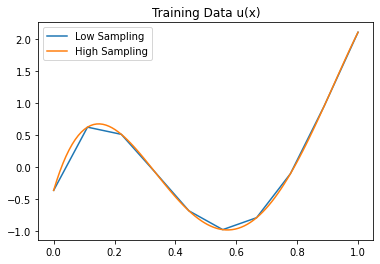

In [3]:
plt.title('Training Data u(x)')
plt.plot(np.linspace(0, 1, sensors[0]),input_u[0][1])
plt.plot(np.linspace(0, 1, sensors[1]),input_u[1][1])
plt.legend(['Low Sampling', 'High Sampling'])

In [17]:
def init_params(layers:list):
    params = []

    key_ = jax.random.PRNGKey(seed=0)
    for i in range(len(layers)-1):
        key_, subkey_ = jax.random.split(key=key_)
        W = jax.random.normal(key=subkey_, shape=(layers[i],layers[i+1]))
        b = jnp.zeros(shape=(layers[i+1],))

        params.append(dict(weights=W, biases=b))

    return params

def forward(X, params:list): 
    hidden = params[:-1]
    last = params[-1]

    for layer in hidden:
        Z = jnp.dot(X,layer['weights']) + layer['biases']
        X = jax.nn.relu(Z)

    A = jnp.dot(X,last['weights']) + last['biases']

    return A

def loss(X,Y,params:list):
    A = forward(X,params)
    return jnp.mean((A-Y)**2)

@jax.jit
def update(X,Y,params:list,lr):
    # Computing Gradients
    grads = jax.grad(loss, argnums=(2))(X,Y,params)

    # SGD Update
    return jax.tree_map(lambda p,g:p-lr*g, params, grads)

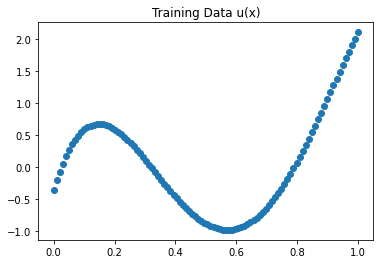

In [14]:
X = np.expand_dims(np.linspace(0, 1, sensors[1]), axis=-1)
Y = np.expand_dims(input_u[1][1], axis=-1)

plt.title('Training Data u(x)')
plt.scatter(X,Y)

In [19]:
params = init_params([1,128,128,1])

num_iter = 5000
lr = 0.0001

num_epochs = 5000
for _ in range(num_epochs):
    params = update(X, Y, params, lr)

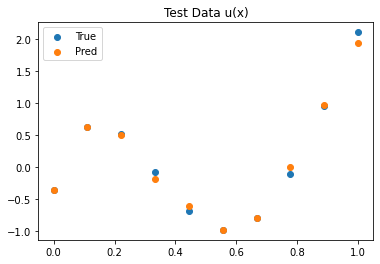

In [25]:
X_test = np.expand_dims(np.linspace(0, 1, sensors[0]), axis=-1)
Y_test = np.expand_dims(input_u[0][1], axis=-1)

plt.title('Test Data u(x)')
plt.scatter(X_test, Y_test, label="True")
plt.scatter(X_test, forward(X_test, params), label="Pred")
plt.legend()